In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import read_summary

# Create a dataframe and units dict from any result summary files found:
pattern = './runs/*/result_summary.txt'
results, units = read_summary.df_from_pattern(pattern)
print('Loaded %i result files.' % len(results))
print('Columns/units:')
print(units)
print()

loading ./runs/panasas-1-1-300-0-POSIX/result_summary.txt
loading ./runs/panasas-1-2-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-1-1-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-1-2-300-0-POSIX/result_summary.txt
loading ./runs/panasas-1-4-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-1-4-300-0-POSIX/result_summary.txt
loading ./runs/panasas-1-16-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-1-16-300-0-POSIX/result_summary.txt
loading ./runs/panasas-2-2-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-2-2-300-0-POSIX/result_summary.txt
loading ./runs/panasas-10-2-300-0-POSIX/result_summary.txt
loading ./runs/quobyte-10-2-300-0-POSIX/result_summary.txt
loading ./runs/panasas-1-1-300-1-POSIX/result_summary.txt
loading ./runs/panasas-1-1-300-2-POSIX/result_summary.txt
loading ./runs/quobyte-1-1-300-1-POSIX/result_summary.txt
loading ./runs/quobyte-1-1-300-2-POSIX/result_summary.txt
loading ./runs/panasas-1-2-300-1-POSIX/result_summary.txt
loading ./

In [2]:
# Define utilities
def describe(df):
    """ Given a dataframe, return a dict (constants, variables) where both are dicts keyed by column name:
            - Values in `constants` are the single value from that column.
            - Values in `variables` are a list of sorted unique values from that column.
    """
    constants = {}
    variables = {}
    for c in df.columns:
        vs = set(df[c])
        if len(vs) == 1:
            constants[c] = df[c].iloc[0]
        else:
            variables[c] = sorted(list(vs))
    return constants, variables

# Characterise columns as bandwidth, IOPs, or descriptive:
# print('units:', units)
bw_unit = 'GiB/s'
iops_unit = 'kIOPS'
score_cols = [c for c, u in units.items() if 'score' in c]
print('score_cols:', score_cols)
descr_cols = [c for c, u in units.items() if (u is None and 'score' not in c)]
print('descr_cols:', descr_cols)
bw_cols = [c for c, u in units.items() if (u == bw_unit and 'score' not in c)]
print('bw_cols:', bw_cols)
iops_cols = [c for c, u in units.items() if (u == iops_unit and 'score' not in c)]
print('iops_cols:', iops_cols)

print('Test matrix summary:')
result_consts, result_vars = describe(results[descr_cols])
for k, v in result_consts.items():
    print(k, ':', v)
for k, v in result_vars.items():
    print(k,':', list(v))

score_cols: ['bandwidth-score', 'iops-score', 'total-score']
descr_cols: ['nodes', 'ntasks_per_node', 'filesystem.name', 'filesystem.mountpoint', 'stonewall', 'iters', 'time', 'ior_api']
bw_cols: ['ior-easy-write', 'ior-hard-write', 'ior-easy-read', 'ior-hard-read']
iops_cols: ['mdtest-easy-write', 'mdtest-hard-write', 'find', 'mdtest-easy-stat', 'mdtest-hard-stat', 'mdtest-easy-delete', 'mdtest-hard-read', 'mdtest-hard-delete']
Test matrix summary:
stonewall : 300
time : 4:0:0
nodes : [1, 2, 10]
ntasks_per_node : [1, 2, 4, 16]
filesystem.name : ['panasas', 'pure', 'quobyte']
filesystem.mountpoint : ['/gws/nopw/j04/perf_testing3/stackhpc', '/gws/pw/j07/perf_testing3', '/work/stackhpc-pure/']
iters : [0, 1, 2]
ior_api : ['MPIIO', 'POSIX']


In [3]:
def split_tests(df):
    """ Split a dataframe into separate bandwidth and IOPS dataframes, contained in a "metrics" dict """
    bw_results = df[descr_cols + bw_cols]
    iops_results = df[descr_cols + iops_cols]
    score_results = df[score_cols]

    metrics = {
        'bandwidth': {
            'name': 'Bandwidth',
            'cols': bw_cols,
            'results': bw_results,
            'unit': bw_unit,
        },
        'iops': {
            'name': 'IOPs',
            'cols': iops_cols,
            'results': iops_results,
            'unit': iops_unit,
        },
        # 'score': {
        #     'name': 'score',
        #     'cols': score_cols,
        #     'results': score_results,
        #     'unit': 'various',
    }
    return metrics

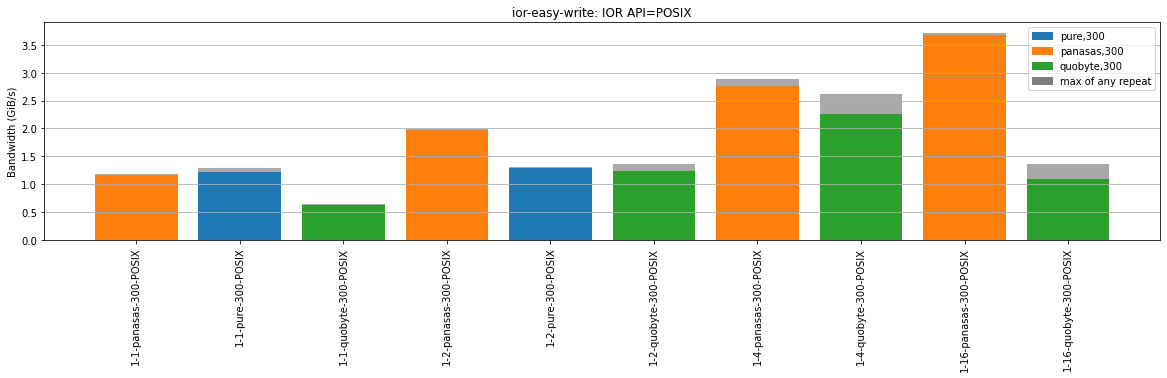

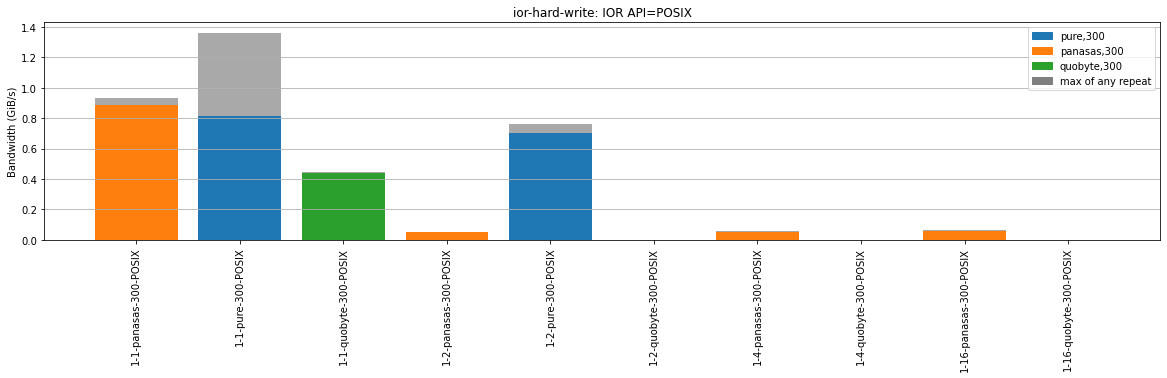

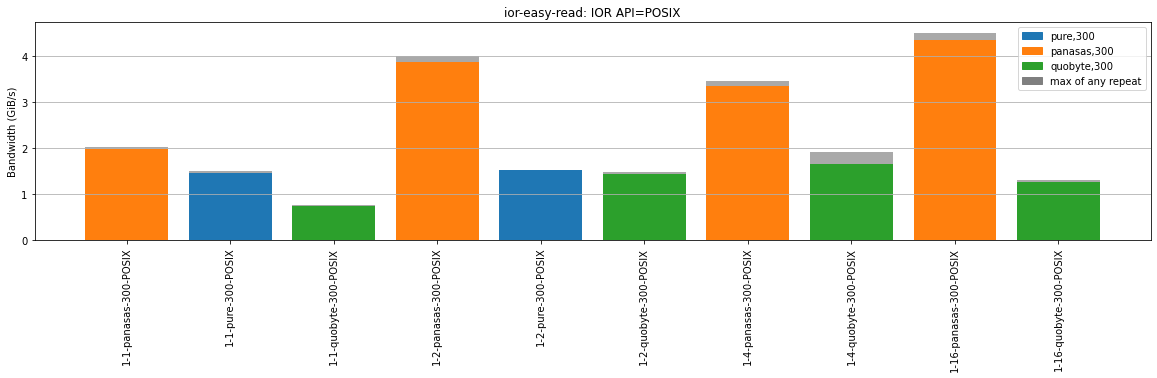

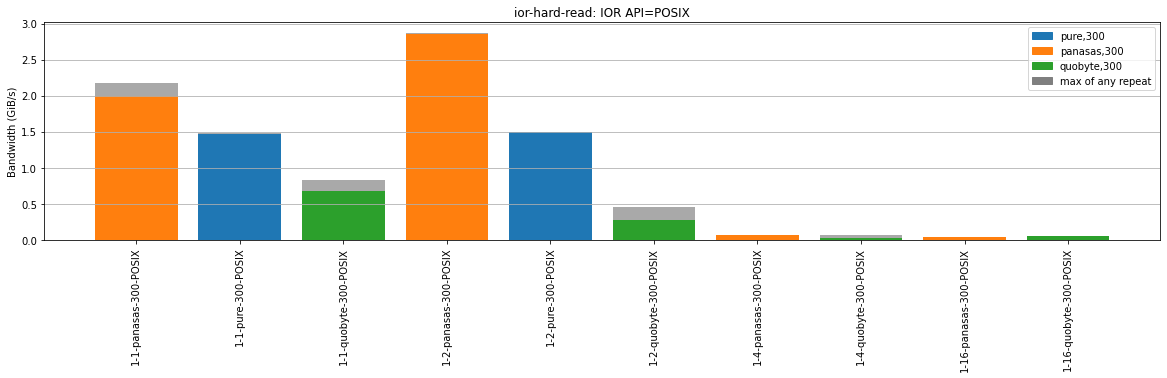

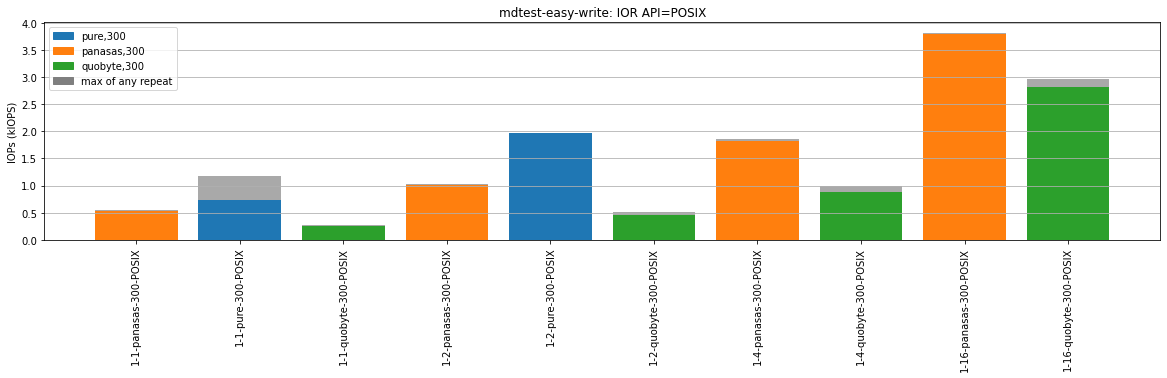

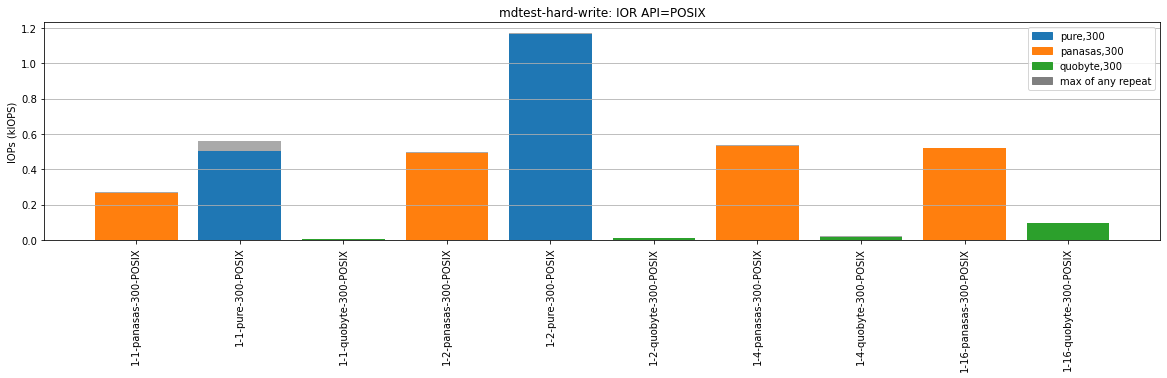

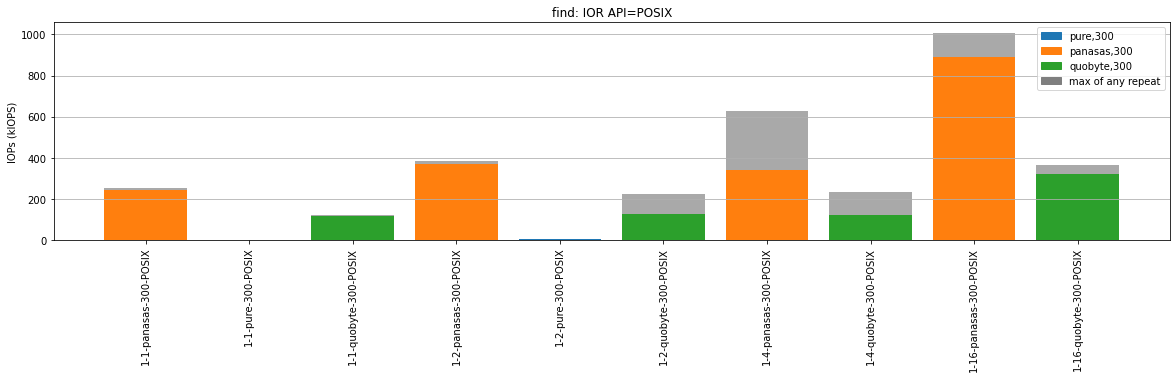

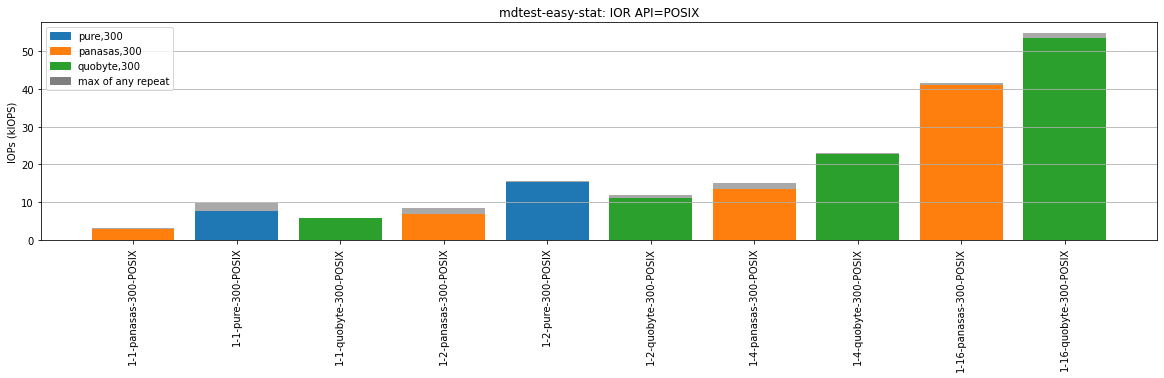

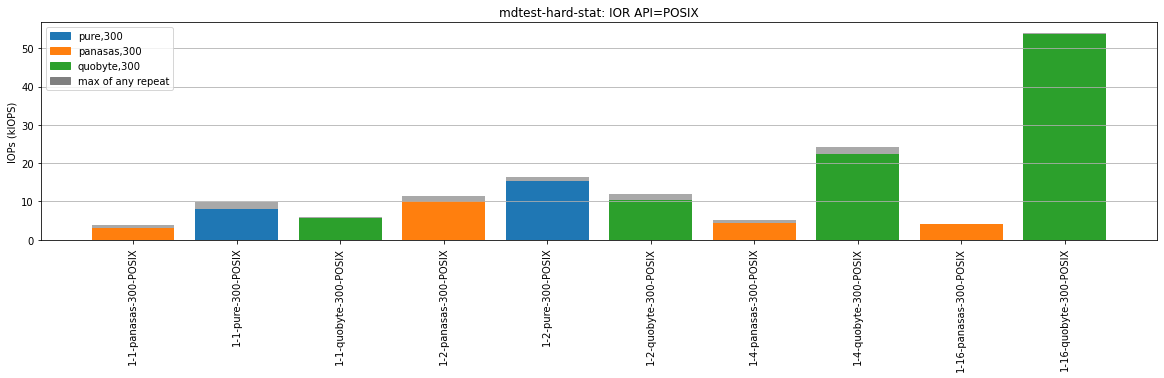

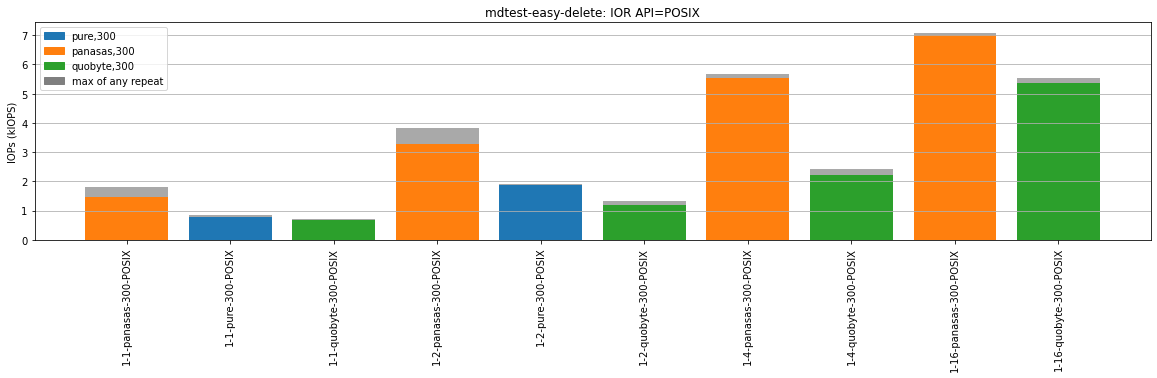

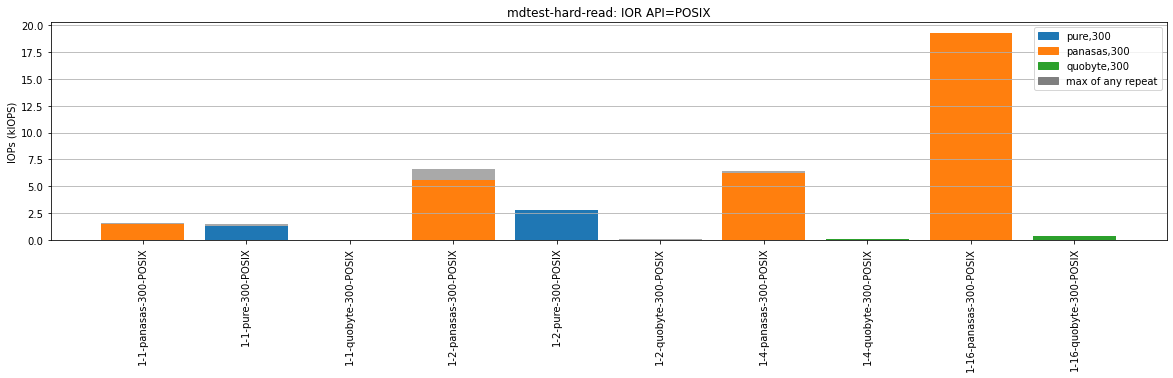

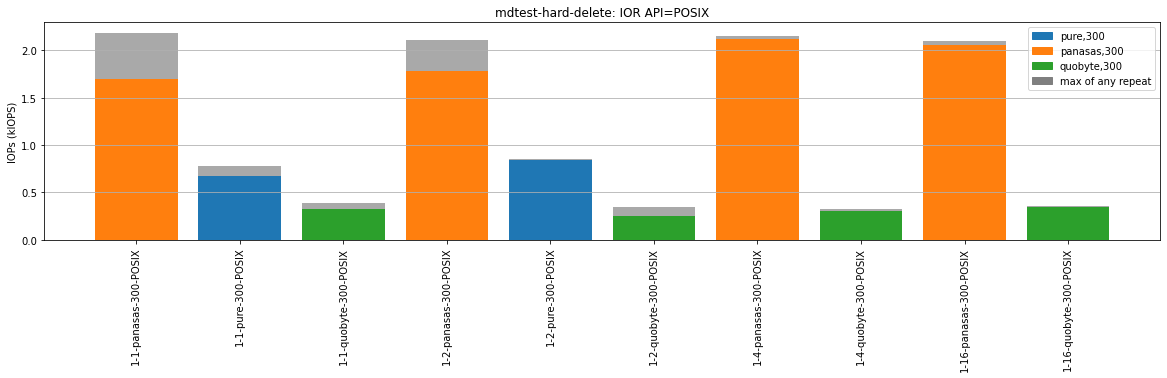

In [4]:
# Plot 2x barcharts per row, MPIIO and POSIX apis, where a row is an io500 test e.g. ior-easy-write.
# Bars are coloured by stonewall time and filesystem.

import matplotlib.patches as mpatches

grouper = ['nodes', 'ntasks_per_node', 'filesystem.name', 'stonewall', 'ior_api']
filtered_results = results.loc[results['ior_api'] == 'POSIX']
filtered_results = filtered_results.loc[results['nodes'] == 1]
metrics = split_tests(filtered_results)
color_options = { # see tableau palette https://matplotlib.org/stable/gallery/color/named_colors.html
                # ('pure', 30): 'tab:cyan',
                ('pure', 300): 'tab:blue',
                # ('panasas', 30): 'tab:orange',
                ('panasas', 300): 'tab:orange',
                # ('quobyte', 30): 'tab:green',
                ('quobyte', 300): 'tab:green',
                ('max of any repeat',): 'tab:gray',
}

legend_entries = [mpatches.Patch(color=v, label=','.join([str(x) for x in k])) for k, v in color_options.items()]
    

for im, (metric_name, metric) in enumerate(metrics.items()):
    for ic, col in enumerate(metric['cols']):
        col_results = metric['results'][descr_cols + [col]]

        grouped = col_results.groupby('ior_api')
        fig, axs = plt.subplots(figsize=(20, 4), nrows=1, ncols=len(grouped), sharey=True)
        for ig, (g, group) in enumerate(grouped):
            ax = axs[ig] if len(grouped) > 1 else axs
            mins = group.groupby(grouper).min().reset_index() # reset ditches heirarchical index
            maxs = group.groupby(grouper).max().reset_index()
            
            barcolors = [color_options[z] for z in zip(mins['filesystem.name'], mins['stonewall'])]
            
            labels = mins[grouper].astype(str).agg('-'.join, axis='columns')
            y_pos=range(len(mins))
            ax.bar(y_pos, maxs[col], width=0.8, label='min', color='darkgray')
            ax.bar(y_pos, mins[col], width=0.8, label='max', color=barcolors)
            ax.set_xticks(y_pos, labels, rotation=90)
            ax.set_ylabel(f"{ metric['name'] } ({ metric['unit'] })")
            ax.set_title(f'{ col }: IOR API={ g }')
            ax.grid(visible=True, axis='y')
            # sharey turns off tick labels on the shared axes. However resetting as below breaks github rendering:
            # ax.tick_params(axis='y', labelleft=True)
        if len(grouped) > 1: # only add legend to RH plot:
            axs[1].legend(handles=legend_entries)
        else:
            axs.legend(handles=legend_entries)

In [5]:
results.to_csv('all-results.csv')